In [72]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import cv2
import numpy as np
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
import random

In [18]:
print(im_content)

None


In [127]:
noise = np.random.uniform(
        im_content.mean()-im_content.std(), im_content.mean()+im_content.std(),
        (im_content.shape)).astype('float32')
img_initial = noise * input_noise + im_content * (1 - input_noise)


(227, 164, 3)
(200, 252, 3)


[]

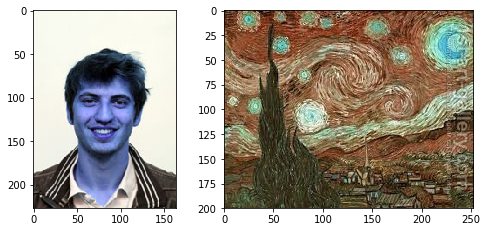

In [126]:
VGG19_mean = np.array([103.939, 116.779, 123.68]).reshape((1,1,3))
fig=plt.figure(figsize=(16, 8))

im_content_real=cv2.imread("image_content.jpg")
print(im_content_real.shape)
fig.add_subplot(2, 1, 1)
im_content=cv2.resize(im_content_real,(224,224))-VGG19_mean
plt.imshow(im_content_real)


im_style_real=cv2.imread("image_style.jpg")
print(im_style_real.shape)
fig.add_subplot(2, 2, 2)
im_style=cv2.resize(im_style_real,(224,224))-VGG19_mean
plt.imshow(im_style_real)
plt.plot()

In [89]:
def show_operation():
    graph = tf.get_default_graph()
    for node in graph.get_operations():
        print(node.name)

In [74]:
def get_operation_name(name):
    graph = tf.get_default_graph()
    for node in graph.get_operations():
        if (node.name==name):
            return node.values()[0]
    return None

In [93]:
input_noise = 0.1     # proportion noise to apply to content image
weight_style = 2e2
layers_style_weights = [0.2,0.2,0.2,0.2,0.2]
layer_content="vgg_19/conv4/conv4_2/Relu"
layers_style = ["vgg_19/conv1/conv1_1/Relu","vgg_19/conv2/conv2_1/Relu","vgg_19/conv3/conv3_1/Relu","vgg_19/conv4/conv4_1/Relu","vgg_19/conv5/conv5_1/Relu"]

In [103]:
img.get_shape().as_list()

[3, 28, 28, 512]

In [116]:
epoch = 20
batch_size = 16
tf.reset_default_graph()

# Input features and output targets.
features=tf.placeholder(tf.float32,shape=[1,224,224,3])
targets=tf.placeholder(tf.float32,shape=[1,224,224,3])
with tf.name_scope('Iterator'):
# Create separate Datasets for training and validation
    train_dataset = tf.data.Dataset.from_tensor_slices((features, targets))
    train_dataset = train_dataset.repeat()

    val_dataset = tf.data.Dataset.from_tensor_slices((features, targets))
    val_dataset = val_dataset

# Iterator has to have same output types across all Datasets to be used
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
    img_content, img_style = iterator.get_next()
    
# Initialize with required Datasets
train_iterator = iterator.make_initializer(train_dataset)
val_iterator = iterator.make_initializer(val_dataset)

In [117]:
img_content

<tf.Tensor 'Iterator/IteratorGetNext:0' shape=(224, 224, 3) dtype=float32>

In [118]:

# img_content=tf.placeholder(tf.float32,shape=[224,224,3])
# img_noice=tf.placeholder(tf.float32,shape=[254,254,3])
# img_style=tf.placeholder(tf.float32,shape=[224,224,3])

with tf.variable_scope("noice_var"):
    img_noice=tf.Variable(dtype=tf.float32,initial_value=tf.random_uniform(minval=0,maxval=1,shape=[224,224,3]))



vgg = tf.contrib.slim.nets.vgg
logits, _ = vgg.vgg_19([img_content,img_style,img_noice])
model_path="vgg_19.ckpt"
variables_model = tf.contrib.framework.get_variables()[1:]
init = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_model)
img = get_operation_name(layer_content)

P_5_2 = img[0]
print(P_5_2)

F_5_2 = img[2]
print(F_5_2)

A_5_2 = img[1]
print(A_5_2)

N=512
M=14*14
K = 1. / (2. * N**0.5 * M**0.5)
loss_content=K*tf.reduce_sum(tf.square(P_5_2-F_5_2))
print(loss_content)


def gram_matrix(x, M, N):
    F = tf.reshape(x, (M, N))                   
    G = tf.matmul(tf.transpose(F), F)
    return G

def style_layer_loss(a, x, M, N):
    A = gram_matrix(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

loss_style=0
for l_style in layers_style:
    style_layer = get_operation_name(layer_content)
    shape_l_style = style_layer.get_shape().as_list()
    loss_style = loss_style + 0.2*style_layer_loss(style_layer[1],style_layer[2],shape_l_style[1]*shape_l_style[2],shape_l_style[3])

loss = loss_content + weight_style*loss_style


optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      loss, method='L-BFGS-B',var_list=[img_noice])


# optimizer = tf.train.AdamOptimizer()
# train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[0]
# train_op = optimizer.minimize(loss,var_list=[img_noice])

# optimizer = tf.contrib.opt.ScipyOptimizerInterface(
#       loss, method='L-BFGS-B')



# def get_operation_namez():
#     graph = tf.get_default_graph()
#     for node in graph.get_operations():
#         print(node.name)
#     return None
# get_operation_namez()

Tensor("strided_slice:0", shape=(28, 28, 512), dtype=float32)
Tensor("strided_slice_1:0", shape=(28, 28, 512), dtype=float32)
Tensor("strided_slice_2:0", shape=(28, 28, 512), dtype=float32)
Tensor("mul:0", shape=(), dtype=float32)


In [13]:
tf.reset_default_graph()
img_content=tf.placeholder(tf.float32,shape=[1,224,224,3])
# img_noice=tf.placeholder(tf.float32,shape=[1,254,254,3])
img_style=tf.placeholder(tf.float32,shape=[1,224,224,3])

vgg = tf.contrib.slim.nets.vgg
logits, _ = vgg.vgg_19(img_content,scope="vgg_content")
model_path="vgg_19.ckpt"
variables_model = tf.contrib.framework.get_variables()
init_content = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_model)
P_5_2 = get_operation_name('vgg_content/conv5/conv5_2/Relu')
print(P_5_2)

img_noice=tf.Variable(dtype=tf.float32,initial_value=tf.random_uniform(minval=0,maxval=1,shape=[1,224,224,3]))
vgg = tf.contrib.slim.nets.vgg
logits, _ = vgg.vgg_19(img_noice,scope="vgg_noice")
model_path="vgg_19.ckpt"
variables_model_2 = tf.contrib.framework.get_variables()
init_noice = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_model_2)
F_5_2 = get_operation_name('vgg_noice/conv5/conv5_2/Relu')
print(F_5_2)

loss_content=1/2*tf.reduce_sum(tf.square(P_5_2-F_5_2),axis=[0,1,2,3])
print(loss_content)


vgg = tf.contrib.slim.nets.vgg
logits, _ = vgg.vgg_19(img_style,scope="vgg_style")
model_path="vgg_19.ckpt"
variables_model = tf.contrib.framework.get_variables()
init_style = tf.contrib.framework.assign_from_checkpoint_fn(model_path, variables_model)
A_5_2 = get_operation_name('vgg_style/conv5/conv5_2/Relu')
print(A_5_2)

def gram_matrix(x, M, N):
    F = tf.reshape(x, (M, N))                   
    G = tf.matmul(tf.transpose(F), F)
    return G

def style_layer_loss(a, x, M, N):
    A = gram_matrix(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

loss_style = style_layer_loss(A_5_2,F_5_2,14*14,512)

loss = loss_content + loss_style

# tvars=tf.trainable_variables()
# print("teste 123 :",tvars)
# var_image=[var for var in tvars if "noice_var" in var.name]
# print(var_image)
optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      loss, method='L-BFGS-B',var_list=[img_noice])

Tensor("vgg_content/conv5/conv5_2/Relu:0", shape=(1, 14, 14, 512), dtype=float32)
Tensor("vgg_noice/conv5/conv5_2/Relu:0", shape=(1, 14, 14, 512), dtype=float32)
Tensor("mul:0", shape=(), dtype=float32)
Tensor("vgg_style/conv5/conv5_2/Relu:0", shape=(1, 14, 14, 512), dtype=float32)


In [125]:
im_content.std()

87.1897072907181

In [119]:
epoch=10000
sess = tf.Session()
sess.run(tf.global_variables_initializer())
init(sess)
sess.run(train_iterator, feed_dict = {features: [im_content], targets: [im_style] })
noise = np.random.uniform(
        im_content.mean()-im_content.std(), im_content.mean()+im_content.std(),
        (im_content.shape)).astype('float32')
img_initial = noise * input_noise + im_content * (1 - input_noise)

sess.run(tf.assign(img_noice,img_initial))
for e in range(epoch):
    print(e)
    optimizer.minimize(sess)
#     sess.run(train_op,feed_dict={img_content: im_content, img_style: im_style})
    if (e%10==0):
        print("loss :", sess.run(loss))#,feed_dict={img_content: im_content, img_style: im_style}


INFO:tensorflow:Restoring parameters from vgg_19.ckpt
0


KeyboardInterrupt: 

In [120]:
zz = sess.run(img_noice)

In [121]:
zzz = (zz-np.min(zz))/np.max(zz-np.min(zz))*255

In [129]:
img_initial

array([[[237.84493847, 237.66182098, 231.13735924],
        [234.84979076, 241.36531792, 226.25547085],
        [242.5991909 , 245.26111946, 235.23154984],
        ...,
        [234.69531269, 248.77561569, 228.78513832],
        [235.94177074, 249.90355492, 238.89472313],
        [244.50377769, 238.20088196, 228.91130562]],

       [[242.86217613, 243.16388664, 233.15094147],
        [240.63771935, 235.49705944, 228.16161785],
        [246.44407578, 232.82080326, 233.36804924],
        ...,
        [237.87285633, 250.09031677, 239.31137962],
        [245.00675507, 249.18450546, 232.46561546],
        [236.4747488 , 240.05855846, 233.70107384]],

       [[247.90757103, 245.96400032, 237.68283424],
        [236.1978857 , 236.43447933, 230.82778797],
        [233.94679565, 238.29013119, 231.373592  ],
        ...,
        [245.79988976, 237.75174236, 227.70103664],
        [238.58768196, 234.18020535, 239.74871178],
        [246.81274147, 238.92572784, 226.68585701]],

       ...,

      

[]

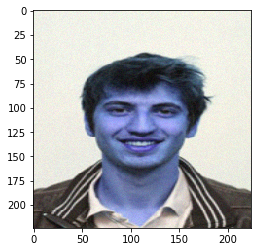

In [130]:
plt.imshow(zzz.astype(int))
plt.plot()

In [ ]:
def gram_matrix(x, M, N):
    F = tf.reshape(x, (M, N))                   
    G = tf.matmul(tf.transpose(F), F)
    return G

def style_layer_loss(a, x):
    _, h, w, d = [i.value for i in a.get_shape()]
    M = h * w 
    N = d 
    A = gram_matrix(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

In [ ]:
import os
import numpy as np
import scipy.misc
import scipy.io
import math
import tensorflow as tf
from sys import stderr
from functools import reduce
import time  

## Inputs 
file_content_image = 'starry_night_mini.jpg' 
file_style_image = 'klimt_2.jpg'   

## Parameters 
input_noise = 0.1     # proportion noise to apply to content image
weight_style = 2e2 

## Layers
layer_content = 'conv4_2' 
layers_style = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers_style_weights = [0.2,0.2,0.2,0.2,0.2]

## VGG19 model
path_VGG19 = 'imagenet-vgg-verydeep-19.mat'
# VGG19 mean for standardisation (RGB)
VGG19_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

## Reporting & writing checkpoint images
# NB. the total # of iterations run will be n_checkpoints * n_iterations_checkpoint
n_checkpoints = 10            # number of checkpoints
n_iterations_checkpoint = 10   # learning iterations per checkpoint
path_output = 'output'  # directory to write checkpoint images into


### Helper functions
def imread(path):
    return scipy.misc.imread(path).astype(np.float)   # returns RGB format

def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
    
def imgpreprocess(image):
    image = image[np.newaxis,:,:,:]
    return image - VGG19_mean

def imgunprocess(image):
    temp = image + VGG19_mean
    return temp[0] 

# function to convert 2D greyscale to 3D RGB
def to_rgb(im):
    w, h = im.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret
 

### Preprocessing
# create output directory
if not os.path.exists(path_output):
    os.mkdir(path_output)

# read in images
img_content = imread(file_content_image) 
img_style = imread(file_style_image) 

# convert if greyscale
if len(img_content.shape)==2:
    img_content = to_rgb(img_content)

if len(img_style.shape)==2:
    img_style = to_rgb(img_style)

# resize style image to match content
img_style = scipy.misc.imresize(img_style, img_content.shape)

# apply noise to create initial "canvas" 
noise = np.random.uniform(
        img_content.mean()-img_content.std(), img_content.mean()+img_content.std(),
        (img_content.shape)).astype('float32')
img_initial = noise * input_noise + img_content * (1 - input_noise)

# preprocess each
img_content = imgpreprocess(img_content)
img_style = imgpreprocess(img_style)
img_initial = imgpreprocess(img_initial)
  

#### BUILD VGG19 MODEL
## with thanks to http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style

VGG19 = scipy.io.loadmat(path_VGG19)
VGG19_layers = VGG19['layers'][0]

# help functions
def _conv2d_relu(prev_layer, n_layer, layer_name):
    # get weights for this layer:
    weights = VGG19_layers[n_layer][0][0][2][0][0]
    W = tf.constant(weights)
    bias = VGG19_layers[n_layer][0][0][2][0][1]
    b = tf.constant(np.reshape(bias, (bias.size)))
    # create a conv2d layer
    conv2d = tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b    
    # add a ReLU function and return
    return tf.nn.relu(conv2d)

def _avgpool(prev_layer):
    return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Setup network
with tf.Session() as sess:
    a, h, w, d     = img_content.shape
    net = {}
    net['input']   = tf.Variable(np.zeros((a, h, w, d), dtype=np.float32))
    net['conv1_1']  = _conv2d_relu(net['input'], 0, 'conv1_1')
    net['conv1_2']  = _conv2d_relu(net['conv1_1'], 2, 'conv1_2')
    net['avgpool1'] = _avgpool(net['conv1_2'])
    net['conv2_1']  = _conv2d_relu(net['avgpool1'], 5, 'conv2_1')
    net['conv2_2']  = _conv2d_relu(net['conv2_1'], 7, 'conv2_2')
    net['avgpool2'] = _avgpool(net['conv2_2'])
    net['conv3_1']  = _conv2d_relu(net['avgpool2'], 10, 'conv3_1')
    net['conv3_2']  = _conv2d_relu(net['conv3_1'], 12, 'conv3_2')
    net['conv3_3']  = _conv2d_relu(net['conv3_2'], 14, 'conv3_3')
    net['conv3_4']  = _conv2d_relu(net['conv3_3'], 16, 'conv3_4')
    net['avgpool3'] = _avgpool(net['conv3_4'])
    net['conv4_1']  = _conv2d_relu(net['avgpool3'], 19, 'conv4_1')
    net['conv4_2']  = _conv2d_relu(net['conv4_1'], 21, 'conv4_2')     
    net['conv4_3']  = _conv2d_relu(net['conv4_2'], 23, 'conv4_3')
    net['conv4_4']  = _conv2d_relu(net['conv4_3'], 25, 'conv4_4')
    net['avgpool4'] = _avgpool(net['conv4_4'])
    net['conv5_1']  = _conv2d_relu(net['avgpool4'], 28, 'conv5_1')
    net['conv5_2']  = _conv2d_relu(net['conv5_1'], 30, 'conv5_2')
    net['conv5_3']  = _conv2d_relu(net['conv5_2'], 32, 'conv5_3')
    net['conv5_4']  = _conv2d_relu(net['conv5_3'], 34, 'conv5_4')
    net['avgpool5'] = _avgpool(net['conv5_4'])


### CONTENT LOSS: FUNCTION TO CALCULATE AND INSTANTIATION
# with thanks to https://github.com/cysmith/neural-style-tf

# Recode to be simpler: http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
def content_layer_loss(p, x):
    _, h, w, d = [i.value for i in p.get_shape()]    # d: number of filters; h,w : height, width
    M = h * w 
    N = d 
    K = 1. / (2. * N**0.5 * M**0.5)
    loss = K * tf.reduce_sum(tf.pow((x - p), 2))
    return loss

with tf.Session() as sess:
    sess.run(net['input'].assign(img_content))
    p = sess.run(net[layer_content])  # Get activation output for content layer
    x = net[layer_content]
    p = tf.convert_to_tensor(p)
    content_loss = content_layer_loss(p, x) 


### STYLE LOSS: FUNCTION TO CALCULATE AND INSTANTIATION

def style_layer_loss(a, x):
    _, h, w, d = [i.value for i in a.get_shape()]
    M = h * w 
    N = d 
    A = gram_matrix(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

def gram_matrix(x, M, N):
    F = tf.reshape(x, (M, N))                   
    G = tf.matmul(tf.transpose(F), F)
    return G

with tf.Session() as sess:
    sess.run(net['input'].assign(img_style))
    style_loss = 0.
    # style loss is calculated for each style layer and summed
    for layer, weight in zip(layers_style, layers_style_weights):
        a = sess.run(net[layer])
        x = net[layer]
        a = tf.convert_to_tensor(a)
        style_loss += style_layer_loss(a, x)
        
### Define loss function and minimise
with tf.Session() as sess:
    # loss function
    L_total  = content_loss + weight_style * style_loss 
    
    # instantiate optimiser
    optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      L_total, method='L-BFGS-B',
      options={'maxiter': n_iterations_checkpoint})
    
    init_op = tf.initialize_all_variables()
    sess.run(init_op)
    sess.run(net['input'].assign(img_initial))
    for i in range(1,n_checkpoints+1):
        # run optimisation
        optimizer.minimize(sess)
        
        ## print costs
        stderr.write('Iteration %d/%d\n' % (i*n_iterations_checkpoint, n_checkpoints*n_iterations_checkpoint))
        stderr.write('  content loss: %g\n' % sess.run(content_loss))
        stderr.write('    style loss: %g\n' % sess.run(weight_style * style_loss))
        stderr.write('    total loss: %g\n' % sess.run(L_total))

        ## write image
        img_output = sess.run(net['input'])
        img_output = imgunprocess(img_output)
        timestr = time.strftime("%Y%m%d_%H%M%S")
        output_file = path_output+'/'+timestr+'_'+'%s.jpg' % (i*n_iterations_checkpoint)
        imsave(output_file, img_output)

In [1]:
import tensorflow as tf
tf.reset_default_graph()
saver = tf.train.Saver()
sess=tf.Session()
saver.restore(sess, "vgg_19.ckpt")

ValueError: No variables to save